# **Iterative Modelling (Initial Model V.2)**

In [ ]:
import math
import pandas as pd
from ortools.sat.python import cp_model
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
from shapely.geometry import LineString
import os

In [2]:
def solve_model_v2(df, budget=1000, time_limit_sec=600):
    print(f"\nMODEL V2")
    print(f"Budget: {budget} kEUR | Max Time: {time_limit_sec}s")

    model = cp_model.CpModel()

    # --- 1. CONFIGURATION ---
    SCALE_COST = 100
    SCALE_SCORE = 100
    SCALE_AREA = 1000
    budget_int = int(budget * SCALE_COST)

    # --- 2. DATA ---
    I = df['grid_id'].tolist()
    id_to_idx = {val: i for i, val in enumerate(I)}
    S = ['atelerix', 'martes', 'eliomys', 'oryctolagus']
    
    # Parameters
    area_int = {row['grid_id']: int(row['cell_area_km2'] * SCALE_AREA) for _, row in df.iterrows()}
    q_orig = {}; cost_adapt = {}; has_species = {}
    
    for s in S:
        q_orig[s] = df.set_index('grid_id')[f'suitability_{s}'].to_dict()
        cost_adapt[s] = {r['grid_id']: int(r[f'cost_adaptation_{s}'] * SCALE_COST) for _, r in df.iterrows()}
        # Note: Column names must match your CSV
        col_has = {'atelerix': 'has_atelerix_algirus', 'martes': 'has_martes_martes',
                   'eliomys': 'has_eliomys_quercinus', 'oryctolagus': 'has_oryctolagus_cuniculus'}
        has_species[s] = df.set_index('grid_id')[col_has[s]].to_dict()

    cost_corr_base = df.set_index('grid_id')['cost_corridor'].to_dict()

    # --- 3. GRAPH BUILD (GRID METRIC) ---
    # Here we build the graph using simple topological distance (Hop count or Euclidean on grid)
    # NOT Haversine. This is the key difference from V3.
    G = nx.Graph()
    for _, row in df.iterrows():
        u = row['grid_id']
        u_idx = id_to_idx[u]
        if isinstance(row['neighbors'], str):
            for v in row['neighbors'].replace(';',',').split(','):
                if v in id_to_idx:
                    v_idx = id_to_idx[v]
                    # Simple Cost: Average Friction * 1.0 (Grid Distance)
                    raw_cost = ((cost_corr_base[u] + cost_corr_base[v]) / 2) * 1.0
                    cost_val = int(raw_cost * SCALE_COST)
                    G.add_edge(u_idx, v_idx, weight=cost_val)

    # --- 4. PRE-CALCULATE PATHS (DIJKSTRA) ---
    print("Pre-calculating paths")
    path_reqs = [[None for _ in S] for _ in I]
    
    for s_idx, s in enumerate(S):
        # Sources: where species currently exists
        sources = [i for i, val in enumerate(I) if has_species[s][val]]
        
        # Multi-source Dijkstra (NetworkX)
        # Note: No aggressive pruning here (or very loose), representing V2 state
        try:
            dists, paths = nx.multi_source_dijkstra(G, sources, weight='weight')
        except:
            dists, paths = {}, {} # Handle empty graph case

        for target_idx in range(len(I)):
            if target_idx in paths:
                # Convert node path to edge list
                path_nodes = paths[target_idx]
                edges = []
                for k in range(len(path_nodes)-1):
                    u, v = sorted((path_nodes[k], path_nodes[k+1]))
                    edges.append((u, v))
                path_reqs[target_idx][s_idx] = edges
            elif target_idx in sources:
                path_reqs[target_idx][s_idx] = [] # Already there, no path needed
            else:
                path_reqs[target_idx][s_idx] = None # Unreachable

    # Collect all unique edges needed
    all_edges = set()
    for i in range(len(I)):
        for s_idx in range(len(S)):
            if path_reqs[i][s_idx]:
                all_edges.update(path_reqs[i][s_idx])
    
    # --- 5. CP-SAT MODEL ---
    # Variables
    x = {}; y = {}; z = {}; stress = {}
    for i in range(len(I)):
        stress[i] = model.NewBoolVar(f'stress_{i}')
        for s_idx, s in enumerate(S):
            x[i, s] = model.NewBoolVar(f'x_{i}_{s}')
            y[i, s] = model.NewBoolVar(f'y_{i}_{s}')
    
    for (u, v) in all_edges:
        z[u, v] = model.NewBoolVar(f'z_{u}_{v}')

    # Constraints
    cost_terms = []
    
    for i in range(len(I)):
        grid_id = I[i]
        
        # Conflicts (Martes vs Eliomys)
        model.Add(x[i, 'martes'] + x[i, 'eliomys'] <= 1)
        model.Add(stress[i] >= x[i, 'martes'] + x[i, 'oryctolagus'] - 1)

        for s_idx, s in enumerate(S):
            # Investment Logic
            model.Add(y[i, s] <= x[i, s])
            if not has_species[s][grid_id]:
                model.Add(x[i, s] <= y[i, s])
            
            cost_terms.append(y[i, s] * cost_adapt[s][grid_id])

            # Path Implication (The V2 Innovation)
            p_edges = path_reqs[i][s_idx]
            if p_edges is None:
                model.Add(x[i, s] == 0) # Unreachable
            elif p_edges:
                for e in p_edges:
                    model.AddImplication(x[i, s], z[e])

    # Corridor Costs
    for (u, v), var in z.items():
        # Retrieve cost from graph
        edge_cost = G[u][v]['weight']
        cost_terms.append(var * edge_cost)

    # Budget
    model.Add(sum(cost_terms) <= budget_int)

    # Simplified Equity (10-40% for EVERYONE)
    # This is the "Naive" equity mentioned in V2 justification
    total_area_vars = []
    for i in range(len(I)):
        for s in S:
            total_area_vars.append(x[i, s] * area_int[I[i]])
    
    total_area_expr = sum(total_area_vars)

    for s in S:
        s_area = sum(x[i, s] * area_int[I[i]] for i in range(len(I)))
        # 10% Min, 40% Max (Uniform)
        model.Add(s_area * 100 >= 10 * total_area_expr)
        model.Add(s_area * 100 <= 40 * total_area_expr)

    # Objective
    obj = []
    for i in range(len(I)):
        gid = I[i]
        ai = area_int[gid]
        for s in S:
            # W=1.0 implicit (V2 didn't refine weights yet)
            base = q_orig[s][gid]
            coef = int(base * 1.0 * ai * SCALE_SCORE / SCALE_AREA)
            obj.append(x[i, s] * coef)
            
            added = 3.0 - base
            if added > 0:
                coef_y = int(added * 1.0 * ai * SCALE_SCORE / SCALE_AREA)
                obj.append(y[i, s] * (coef_y - 1))
            else:
                obj.append(y[i, s] * -1)
        
        obj.append(stress[i] * int(-350.0 * SCALE_SCORE))
    
    for (u,v), var in z.items():
        obj.append(var * -1)

    model.Maximize(sum(obj))

    # Solve
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_sec
    solver.parameters.log_search_progress = True
    
    print("Solving V2 Model")
    status = solver.Solve(model)

    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        print(f"Solution Found: {solver.ObjectiveValue() / SCALE_SCORE:.2f}")
        
        res = []
        for i in range(len(I)):
            row = {'grid_id': I[i]}
            for s in S:
                row[f'active_{s}'] = solver.Value(x[i, s])
                row[f'invest_{s}'] = solver.Value(y[i, s])
            
            cors = []
            # Check active edges connected to i
            for neighbor_idx in G[i]:
                u, v = sorted((i, neighbor_idx))
                if (u, v) in z and solver.Value(z[u, v]):
                    cors.append(I[neighbor_idx])
            row['corridors'] = ";".join(cors)
            res.append(row)
        return pd.DataFrame(res)
    else:
        print(f"Failure: {solver.StatusName(status)}")
        return None

df = pd.read_csv('../../2_data/processed/final_dataset.csv')
df_sol_v2 = solve_model_v2(df, budget=1000, time_limit_sec=1800)

if df_sol_v2 is not None:
    df_sol_v2.to_csv('../../5_results/solutions/solution_v2.csv', index=False)
    print("Saved: solution_v2.csv")


MODEL V2
Budget: 1000 kEUR | Max Time: 1800s
Pre-calculating paths
Solving V2 Model
Solution Found: 705.99
Saved: solution_v2.csv


Map saved: ../../5_results/iterations\v2_model_results_map.png


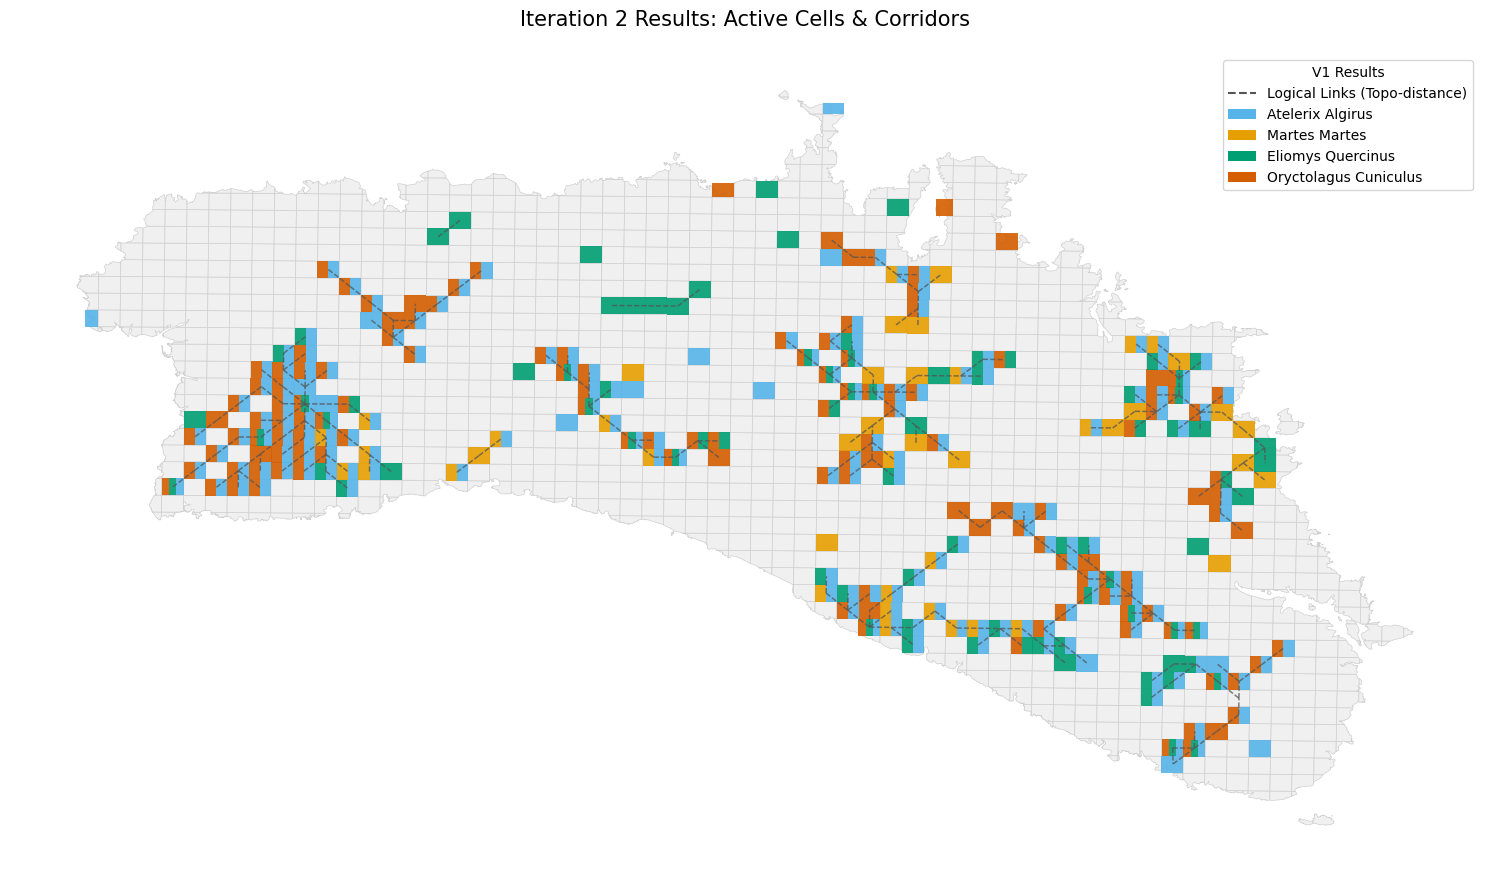

In [5]:
SOLUTION_PATH_V1 = '../../5_results/solutions/solution_v2.csv' 
GEOJSON_PATH = '../../2_data/processed/final_dataset.geojson'
OUTPUT_DIR = '../../5_results/iterations'

gdf = gpd.read_file(GEOJSON_PATH)

df_sol_v1 = pd.read_csv(SOLUTION_PATH_V1)
gdf = gdf.merge(df_sol_v1, on='grid_id', how='left')

SPECIES_COLORS = {
    'martes': '#E69F00',      # Naranja
    'oryctolagus': '#D55E00', # Rojo
    'eliomys': '#009E73',     # Verde
    'atelerix': '#56B4E9'     # Azul
}

fig, ax = plt.subplots(figsize=(15, 12))
ax.set_aspect('equal')
ax.set_title("Iteration 2 Results: Active Cells & Corridors", fontsize=15, pad=20)

gdf.plot(ax=ax, color='#f0f0f0', edgecolor='#d0d0d0', linewidth=0.5)

centroids = {row['grid_id']: (row.geometry.centroid.x, row.geometry.centroid.y) for idx, row in gdf.iterrows()}
corridor_lines = []

if 'corridors' in gdf.columns:
    for idx, row in gdf.iterrows():
        if pd.notna(row['corridors']):
            neighbors = str(row['corridors']).split(';')
            start_pt = centroids.get(row['grid_id'])
            for n_id in neighbors:
                n_id = n_id.strip()
                if n_id in centroids:
                    end_pt = centroids[n_id]
                    corridor_lines.append(LineString([start_pt, end_pt]))

    if corridor_lines:
        gpd.GeoSeries(corridor_lines).plot(ax=ax, color='#555555', linewidth=1.0, alpha=0.5, zorder=2, linestyle='--')

def draw_cell_slices(ax, geom, species_active, colors):
    if not species_active: return
    minx, miny, maxx, maxy = geom.bounds
    width = maxx - minx; height = maxy - miny
    n = len(species_active); slice_w = width / n
    for i, sp in enumerate(species_active):
        rect = Rectangle((minx + i*slice_w, miny), slice_w, height, 
                         facecolor=colors.get(sp, 'grey'), edgecolor='none', alpha=0.9)
        ax.add_patch(rect)

for idx, row in gdf.iterrows():
    active_species = []
    for sp in SPECIES_COLORS.keys():
        col_name = f'active_{sp}' 
        if col_name in row and row[col_name] > 0.5:
            active_species.append(sp)
    
    if active_species:
        draw_cell_slices(ax, row.geometry, active_species, SPECIES_COLORS)

legend_elements = [
    Line2D([0], [0], color='#555555', lw=1.5, linestyle='--', label='Logical Links (Topo-distance)'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['atelerix'], label='Atelerix Algirus'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['martes'], label='Martes Martes'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['eliomys'], label='Eliomys Quercinus'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['oryctolagus'], label='Oryctolagus Cuniculus'),
]

ax.legend(handles=legend_elements, loc='upper right', title="V1 Results")

plt.axis('off')
plt.tight_layout()

out_path = os.path.join(OUTPUT_DIR, 'v2_model_results_map.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print(f"Map saved: {out_path}")
plt.show()